# Hyperparameter: Image Resolution

Exploring the influence of imgae resolution with grey scaled images for gestures like and stop.

## Resoultion Sizes:
- The original image size is 1920 x 1080, but the gestures only require a small part of the overall image. Therefore, resizing the image above a threshold doesn't make sense, hence the maximum size was set to 256 x 256. In some sources the best results for deep learning were archieved with image sizes between 256x256 and 448x448.

- very small resolution: **12x12** 
- small resolution: **32x32** 
- resolution: **64x64** 
- resolution: **128x128** 
- most 'famous' resolutiion: **256x256** 

### Usefull Sources:
- https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015
- https://datascience.stackexchange.com/questions/84664/role-of-image-resolution-in-deep-learning#:~:text=Having%20good%20architecture%20and%20a,%2C%20128x128%2C%20224x224%2C%20256x256.
- https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network
- https://www.quora.com/Which-Image-resolution-should-I-use-for-training-for-deep-neural-network


## My Assumption

I would assume that a network using higher resolution will be able to capture finer details of the images and therefore has higher accuracies. I would also assume that lower image quality will need more epochs to reach a good accuracy than a higher image resolution. But higher image resolution will most probably take more time to process than lower image quality.
12x12 will probably be okay with gestures but not good. 32x32 will be faster but still not good enough. Same for 64x64. 1228x128 or 256x256 will probably archieve the best results but take longer than the others. Having read the sources most probably 256x256 will perform the best and 12x12 the worst.


In [74]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

In [75]:
# include only those gestures
CONDITIONS = ['like', 'stop']

# Path to HaGRID dataset -> has to be adjsuted!
PATH = '../data/gesture_dataset_sample'

# image size
IMG_SIZES = [12, 32, 64, 128, 256]

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 1

## helper function to load and parse annotations

In [76]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [77]:
annotations['like']['0014182f-d756-42b3-896c-c52de76926bb']

{'bboxes': [[0.38056273, 0.35650891, 0.17322347, 0.10461114]],
 'labels': ['like'],
 'landmarks': [[[0.5497169170918876, 0.4276043615779976],
   [0.5218336293004483, 0.40536586667786917],
   [0.48288133220125257, 0.3930262243722419],
   [0.4501841862302019, 0.37981099195030416],
   [0.44251365410099686, 0.36620499322043343],
   [0.43138297470865106, 0.406093902776592],
   [0.4072660997339628, 0.4073950234480344],
   [0.42588200316326846, 0.40612291879594015],
   [0.4441470003072778, 0.4049221293588555],
   [0.4314493576491367, 0.4212979654419442],
   [0.42096276272263283, 0.4180224457320293],
   [0.43966095717106257, 0.4163441895714394],
   [0.45584443128098306, 0.41643247458990734],
   [0.4399742832485622, 0.4347478484477659],
   [0.43512361573721164, 0.42874760405890505],
   [0.44966112930536684, 0.42732603739798153],
   [0.46521777606118425, 0.42773384627175054],
   [0.4497130758396873, 0.44628828496441647],
   [0.4430629908914239, 0.4396031525669027],
   [0.4567531364734271, 0.4381

In [78]:
# pretty-print first element
# print(json.dumps(annotations['like']['000484ab-5fd0-49b8-9253-23a22b71d7b1'], indent=2))

# this data ^ was not in the dataset changed to value that is there

print(json.dumps(annotations['like']['0014182f-d756-42b3-896c-c52de76926bb'], indent=2))

{
  "bboxes": [
    [
      0.38056273,
      0.35650891,
      0.17322347,
      0.10461114
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.5497169170918876,
        0.4276043615779976
      ],
      [
        0.5218336293004483,
        0.40536586667786917
      ],
      [
        0.48288133220125257,
        0.3930262243722419
      ],
      [
        0.4501841862302019,
        0.37981099195030416
      ],
      [
        0.44251365410099686,
        0.36620499322043343
      ],
      [
        0.43138297470865106,
        0.406093902776592
      ],
      [
        0.4072660997339628,
        0.4073950234480344
      ],
      [
        0.42588200316326846,
        0.40612291879594015
      ],
      [
        0.4441470003072778,
        0.4049221293588555
      ],
      [
        0.4314493576491367,
        0.4212979654419442
      ],
      [
        0.42096276272263283,
        0.4180224457320293
      ],
      [
        0.43966095717106257,
      

## helper function to pre-process images (color channel conversion and resizing)

In the following i changed the cells into functions so i can run differrent image sizes at once

In [79]:
def preprocess_image(img, img_size):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    try:
        img_resized = cv2.resize(img, (img_size, img_size))
    except:
        print(f'File could not be preprocessed: {img}')
        return None
    return img_resized

## load images and annotations

In [80]:
def prepare_data(img_size):

    images = [] # stores actual image data
    labels = [] # stores labels (as integer - because this is what our network needs)
    label_names = [] # maps label ints to their actual categories so we can understand predictions later

    # loop over all conditions
    # loop over all files in the condition's directory
    # read the image and corresponding annotation
    # crop image to the region of interest
    # preprocess image
    # store preprocessed image and label in corresponding lists
    for condition in CONDITIONS:
        print(f'Current condition: {condition}')
        for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
            # extract unique ID from file name
            UID = filename.split('.')[0]
            img = cv2.imread(f'{PATH}/{condition}/{filename}')
            # get annotation from the dict we loaded earlier
            try:
                annotation = annotations[condition][UID]
            except Exception as e:
                print(e)
                continue
            
            # iterate over all hands annotated in the image
            for i, bbox in enumerate(annotation['bboxes']):
                # annotated bounding boxes are in the range from 0 to 1
                # therefore we have to scale them to the image size
                x1 = int(bbox[0] * img.shape[1])
                y1 = int(bbox[1] * img.shape[0])
                w = int(bbox[2] * img.shape[1])
                h = int(bbox[3] * img.shape[0])
                x2 = x1 + w
                y2 = y1 + h
                
                # crop image to the bounding box and apply pre-processing
                crop = img[y1:y2, x1:x2]
                preprocessed = preprocess_image(crop, img_size=img_size)
                if preprocessed is not None:
                    # get the annotated hand's label
                    # if we have not seen this label yet, add it to the list of labels
                    label = annotation['labels'][i]
                    if label not in label_names:
                        label_names.append(label)
                    
                    label_index = label_names.index(label)
                    
                    images.append(preprocessed)
                    labels.append(label_index)
    
    return images, labels, label_names

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [81]:
def split_prepare_train_test(images, labels, size):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    X_train = np.array(X_train).astype('float32')
    X_train = X_train / 255.

    X_val = np.array(X_val).astype('float32')
    X_val = X_val / 255.

    X_test = np.array(X_test).astype('float32')
    X_test = X_test / 255.

    y_train_one_hot = to_categorical(y_train)
    y_val_one_hot = to_categorical(y_val)
    y_test_one_hot = to_categorical(y_test)

    train_label = y_train_one_hot
    test_label = y_test_one_hot
    val_label = y_val_one_hot

    X_train = X_train.reshape(-1, size, size, COLOR_CHANNELS)
    X_test = X_test.reshape(-1, size, size, COLOR_CHANNELS)
    X_val = X_val.reshape(-1, size, size, COLOR_CHANNELS)
    return X_train, train_label, X_val, val_label, X_test, test_label, y_test

In [82]:
def prepare_model(label_names, size):
    
    # variables for hyperparameters
    batch_size = 8
    epochs = 50

    num_classes = len(label_names)
    activation = 'relu'
    activation_conv = 'leaky_relu'  # LeakyReLU
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    #model.add(RandomFlip('horizontal'))
    #model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(size, size, COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    return model, batch_size, epochs, reduce_lr, stop_early


## now, we can train the model using the fit() function
## this will take a while

In [83]:
def fit_model(model, batch_size, epochs, reduce_lr, stop_early, X_train, train_labels, X_val, val_labels):
    history = model.fit(
        X_train,
        train_labels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, val_labels),
        callbacks=[reduce_lr, stop_early]
    )
    
    return history

In [84]:
# let's have a look at our model
# model.summary()

In [85]:
def train(size):
    images, labels, label_names = prepare_data(size)
    X_train, train_labels, X_val, val_labels, X_test, test_labels, y_test = split_prepare_train_test(images, labels, size)
    model, batch_size, epochs, reduce_lr, stop_early = prepare_model(label_names, size)
    return images[0], X_test, test_labels, y_test, label_names, model, fit_model(model, batch_size, epochs, reduce_lr, stop_early, X_train, train_labels, X_val, val_labels)

In [86]:
# store all values for comparison

times_train = []
times_test = []
accuracies = []
losses = []
confusions = []
example_images = []
size_hist = []


# Test the Conditions

In [87]:
for size in IMG_SIZES:
    print(f'Start with size {size}!')
    start_time = time.time()

    example_img, X_test, test_labels, y_test, label_names, model, hist = train(size)
    times_train.append((time.time() - start_time))

    losses.append(hist.history['val_loss'])
    accuracies.append(hist.history['val_accuracy'])


    # let the model make predictions on test data
    start_time_test = time.time()
    y_predictions = model.predict(X_test)
    times_test.append(time.time() - start_time_test)

    print(f'\nModel summary image size {size}x{size}:')
    model.summary()

    y_predictions = np.argmax(y_predictions, axis=1)
    conf_matrix = confusion_matrix(y_test, y_predictions)
    confusions.append((conf_matrix, label_names))


    example_images.append(example_img)
    size_hist.append((IMG_SIZES[0], hist))

Start with size 12!
Current condition: like


  0%|          | 0/250 [00:00<?, ?it/s]

Current condition: stop


  0%|          | 0/250 [00:00<?, ?it/s]

/Users/luca/Projekte/Master/ITT/W6/assignment-5-cnn-LucaEscher/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3747 - loss: 1.0747 - val_accuracy: 0.3495 - val_loss: 1.0775 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3665 - loss: 1.1025 - val_accuracy: 0.4563 - val_loss: 1.0203 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4271 - loss: 1.0529 - val_accuracy: 0.4563 - val_loss: 1.0053 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4263 - loss: 1.0462 - val_accuracy: 0.3495 - val_loss: 1.0254 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4283 - loss: 1.0109 - val_accuracy: 0.4854 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4630 - loss: 0.9288 - val_accuracy: 0.4369 - val_loss: 0.9253 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5030 - loss: 0.8739 - val_accuracy: 

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 12, 12, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 3, 3, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 1, 1, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,587 (846.05 KB)

 Trainable params: 72,195 (282.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,392 (564.04 KB)

Start with size 32!
Current condition: like


  0%|          | 0/250 [00:00<?, ?it/s]

Current condition: stop


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50


/Users/luca/Projekte/Master/ITT/W6/assignment-5-cnn-LucaEscher/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4243 - loss: 1.0739 - val_accuracy: 0.4563 - val_loss: 1.0013 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4387 - loss: 1.0500 - val_accuracy: 0.6311 - val_loss: 0.7846 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5922 - loss: 0.8862 - val_accuracy: 0.7184 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7242 - loss: 0.6405 - val_accuracy: 0.8155 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8509 - loss: 0.4588 - val_accuracy: 0.7767 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8639 - loss: 0.3915 - val_accuracy: 0.8641 - val_loss: 0.4088 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9102 - loss: 0.2495 - val_accuracy: 0.8835 - va

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 3, 3, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,019 (918.05 KB)

 Trainable params: 78,339 (306.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 156,680 (612.04 KB)

Start with size 64!
Current condition: like


  0%|          | 0/250 [00:00<?, ?it/s]

Current condition: stop


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50


/Users/luca/Projekte/Master/ITT/W6/assignment-5-cnn-LucaEscher/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4165 - loss: 1.0465 - val_accuracy: 0.3495 - val_loss: 1.0637 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4035 - loss: 1.0495 - val_accuracy: 0.5146 - val_loss: 1.0224 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4871 - loss: 0.9850 - val_accuracy: 0.6505 - val_loss: 0.8115 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6282 - loss: 0.7925 - val_accuracy: 0.7087 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7287 - loss: 0.5993 - val_accuracy: 0.8835 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7901 - loss: 0.5049 - val_accuracy: 0.8932 - val_loss: 0.4134 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8776 - loss: 0.3240 - val_accuracy: 0.90

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,739 (1.01 MB)

 Trainable params: 88,579 (346.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 177,160 (692.04 KB)

Start with size 128!
Current condition: like


  0%|          | 0/250 [00:00<?, ?it/s]

Current condition: stop


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50


/Users/luca/Projekte/Master/ITT/W6/assignment-5-cnn-LucaEscher/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.3735 - loss: 1.0803 - val_accuracy: 0.4563 - val_loss: 1.0466 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3795 - loss: 1.0460 - val_accuracy: 0.6019 - val_loss: 0.8265 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5471 - loss: 0.8613 - val_accuracy: 0.7184 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7338 - loss: 0.5932 - val_accuracy: 0.9029 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8274 - loss: 0.4014 - val_accuracy: 0.8641 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8907 - loss: 0.3129 - val_accuracy: 0.5922 - val_loss: 1.2033 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.8631 - loss: 0.3366 - val_accuracy: 0.92

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 128, 128, 64)   │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,627 (1.65 MB)

 Trainable params: 143,875 (562.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,752 (1.10 MB)

Start with size 256!
Current condition: like


  0%|          | 0/250 [00:00<?, ?it/s]

Current condition: stop


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50


/Users/luca/Projekte/Master/ITT/W6/assignment-5-cnn-LucaEscher/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.4477 - loss: 1.0975 - val_accuracy: 0.4563 - val_loss: 1.0173 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.3686 - loss: 1.0817 - val_accuracy: 0.3495 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.4594 - loss: 1.0670 - val_accuracy: 0.3495 - val_loss: 1.2310 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 364ms/step - accuracy: 0.4316 - loss: 1.1214 - val_accuracy: 0.5340 - val_loss: 0.9424 - learning_rate: 2.0000e-04
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 365ms/step - accuracy: 0.5402 - loss: 0.9460 - val_accuracy: 0.5534 - val_loss: 0.8582 - learning_rate: 2.0000e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - accuracy: 0.6263 - loss: 0.8287 - val_accuracy: 0.6117 - val_loss: 0.7809 - learning_rate: 2.0000e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.6986 - loss: 0

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 256, 256, 64)   │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │       247,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 953,867 (3.64 MB)

 Trainable params: 317,955 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 635,912 (2.43 MB)

# Comparison

**Print the logs:**

In [88]:
# generated with chatgpt -> see chatgpt.md
def format_duration(seconds):
    # Convert seconds to hours, minutes, seconds, and milliseconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    milliseconds = int((seconds - int(seconds)) * 1000)
    
    # Format the duration string
    formatted_duration = f"{hours} hours, {minutes} minutes, {int(seconds)} seconds, {milliseconds} milliseconds"
    return formatted_duration

# Example usage
duration_in_seconds = 0.13464999198913574
formatted_duration = format_duration(duration_in_seconds)
print(formatted_duration)


0 hours, 0 minutes, 0 seconds, 134 milliseconds


In [89]:
# train and prediction time comparison
for index, img_size in enumerate(IMG_SIZES):
    formatted_train = format_duration(times_train[index])
    formatted_prediction = format_duration(times_test[index])
    print('---------')
    print(f'Image size: {img_size}\ntrain time: {formatted_train}\nprediction time: {formatted_prediction}')
    print('---------')
    

---------
Image size: 12
train time: 0 hours, 0 minutes, 15 seconds, 95 milliseconds
prediction time: 0 hours, 0 minutes, 0 seconds, 57 milliseconds
---------
---------
Image size: 32
train time: 0 hours, 0 minutes, 15 seconds, 971 milliseconds
prediction time: 0 hours, 0 minutes, 0 seconds, 69 milliseconds
---------
---------
Image size: 64
train time: 0 hours, 0 minutes, 21 seconds, 519 milliseconds
prediction time: 0 hours, 0 minutes, 0 seconds, 129 milliseconds
---------
---------
Image size: 128
train time: 0 hours, 0 minutes, 46 seconds, 374 milliseconds
prediction time: 0 hours, 0 minutes, 0 seconds, 310 milliseconds
---------
---------
Image size: 256
train time: 0 hours, 5 minutes, 35 seconds, 700 milliseconds
prediction time: 0 hours, 0 minutes, 1 seconds, 250 milliseconds
---------


In [90]:
# overview accuracies and loss

# train and prediction time comparison
for index, accuracy in enumerate(accuracies):
    print('---------')
    print(f'Image size: {IMG_SIZES[index]}\nAccuracy: {accuracy[-1]}\nLoss: {losses[index][-1]}')
    print('---------')
    

---------
Image size: 12
Accuracy: 0.7766990065574646
Loss: 0.6028813719749451
---------
---------
Image size: 32
Accuracy: 0.9126213788986206
Loss: 0.28702378273010254
---------
---------
Image size: 64
Accuracy: 0.9320388436317444
Loss: 0.28734737634658813
---------
---------
Image size: 128
Accuracy: 0.9320388436317444
Loss: 0.22301320731639862
---------
---------
Image size: 256
Accuracy: 0.9126213788986206
Loss: 0.3014228045940399
---------


## Plot accuracy and loss of the training process

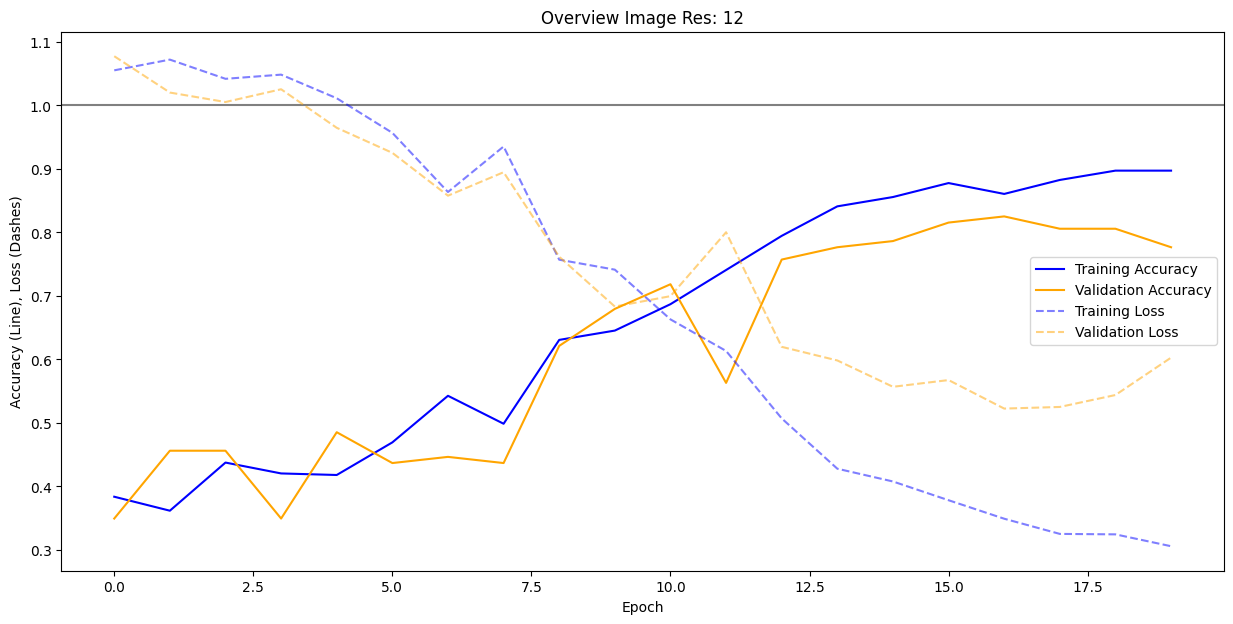

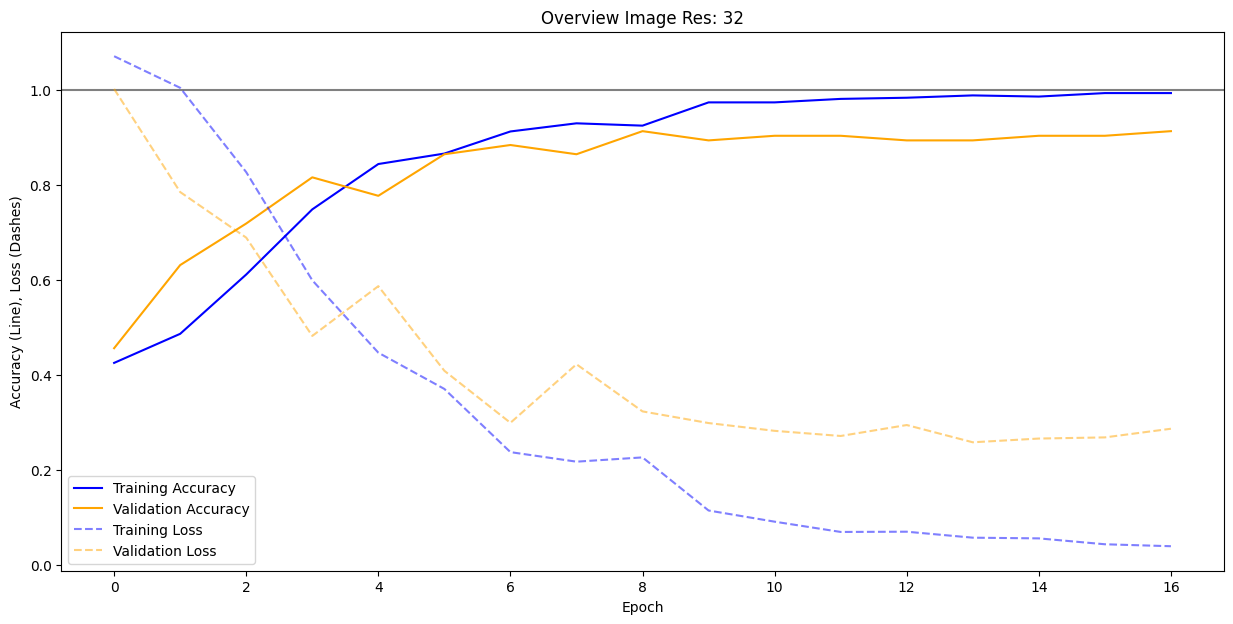

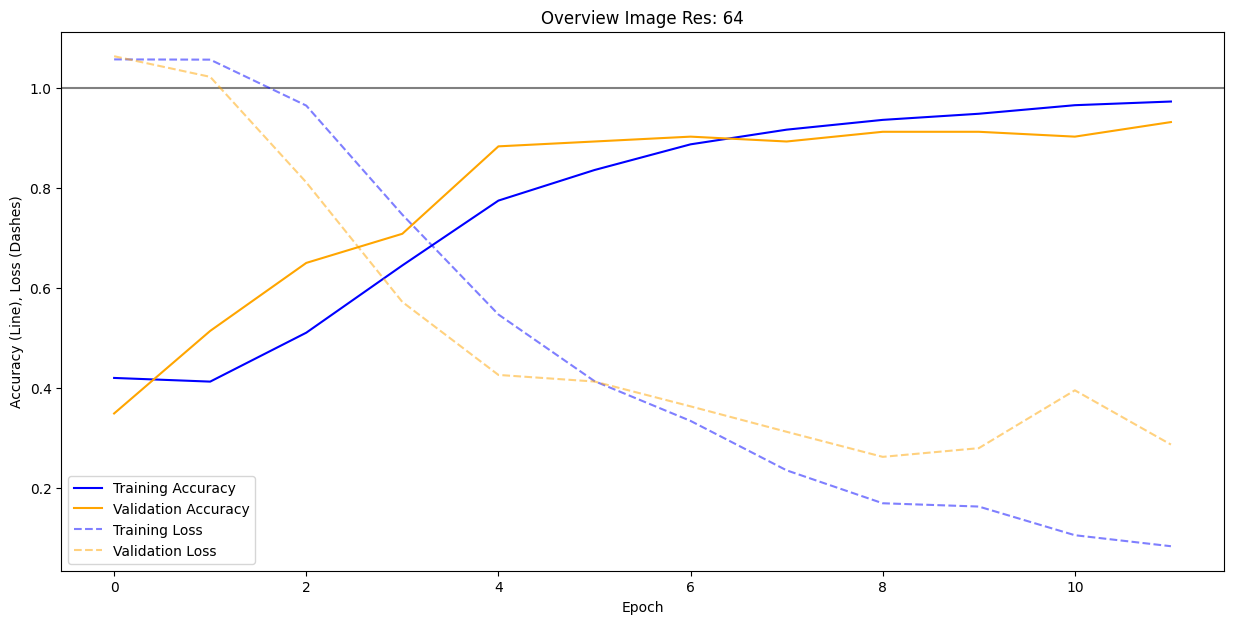

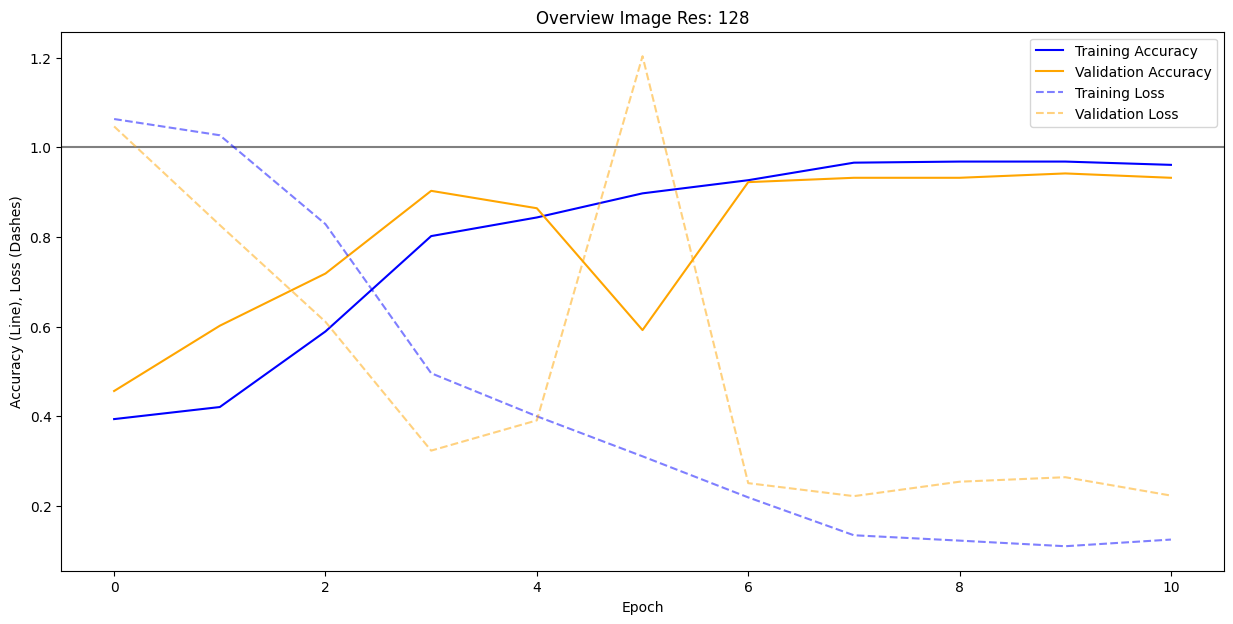

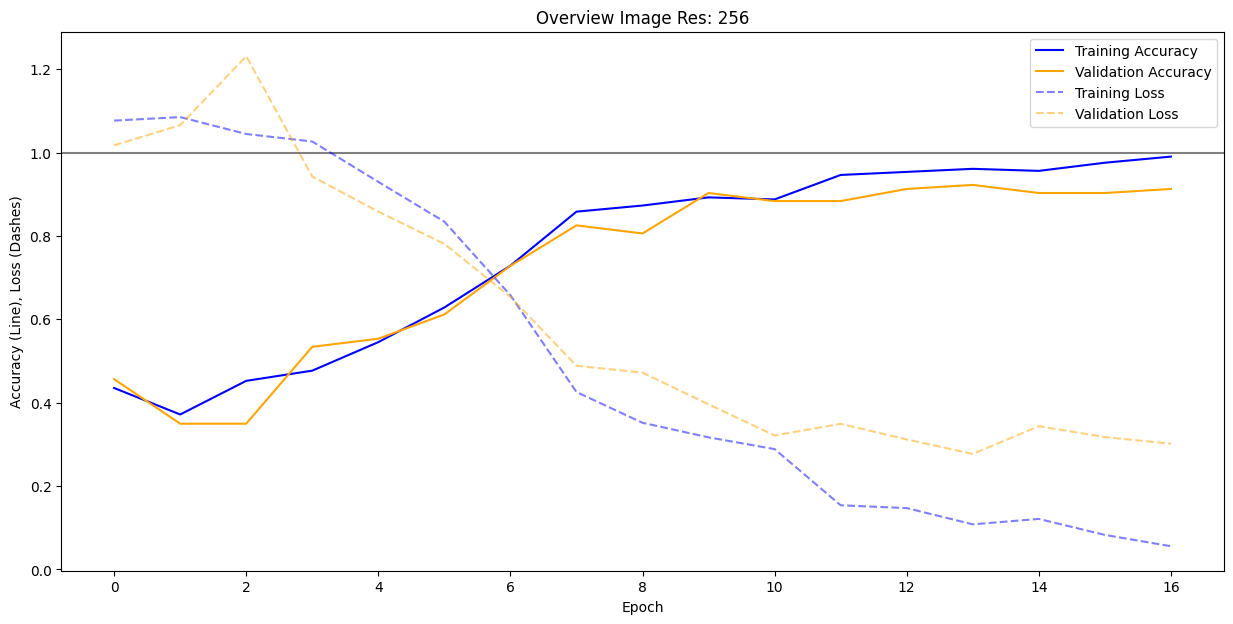

In [91]:
for index, history in enumerate(size_hist):
    size = history[0]
    value = history[1]

    loss = value.history['loss']
    val_loss = value.history['val_loss']
    accuracy = value.history['accuracy']
    val_accuracy = value.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue', label='Training Accuracy')
    plt.plot(val_accuracy, color='orange', label='Validation Accuracy')
    plt.plot(loss, '--', color='blue', alpha=0.5, label='Training Loss')
    plt.plot(val_loss, '--', color='orange', alpha=0.5, label='Validation Loss')

    plt.legend()

    plt.title(f'Overview Image Res: {IMG_SIZES[index]}')

    plt.show()

# Confusion Matrix

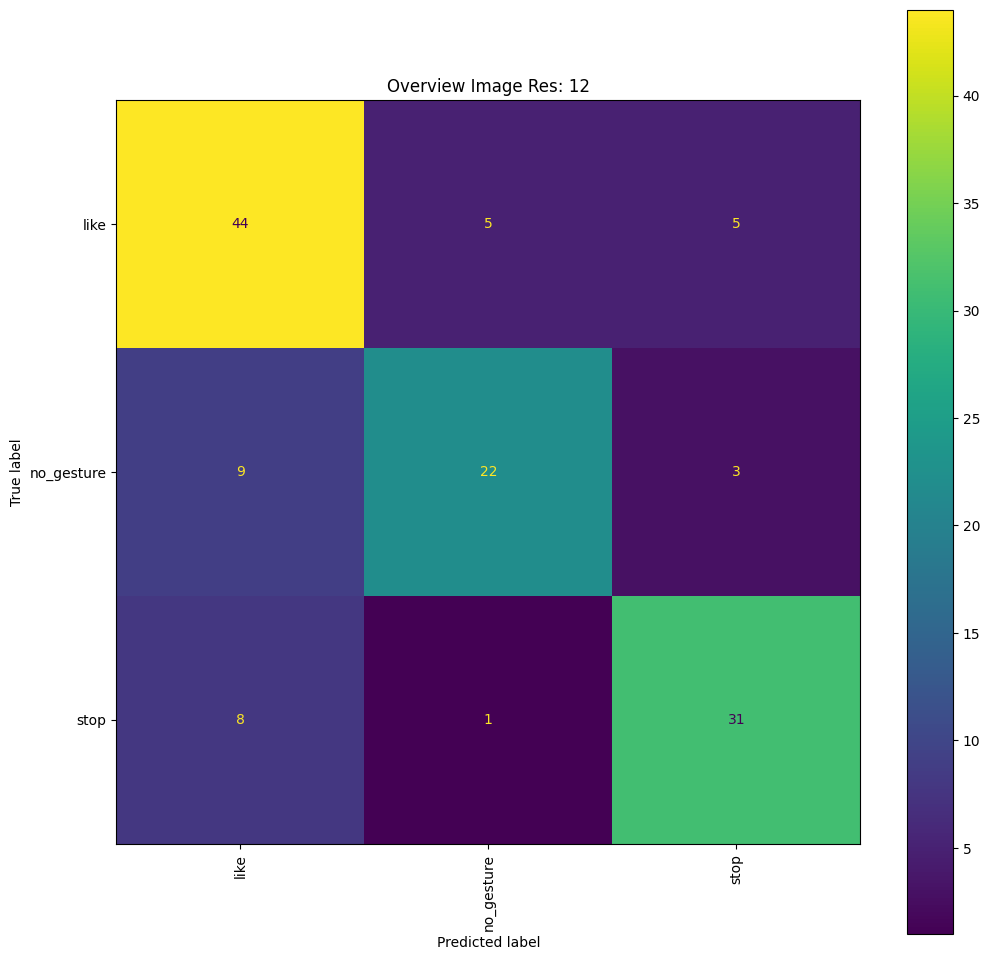

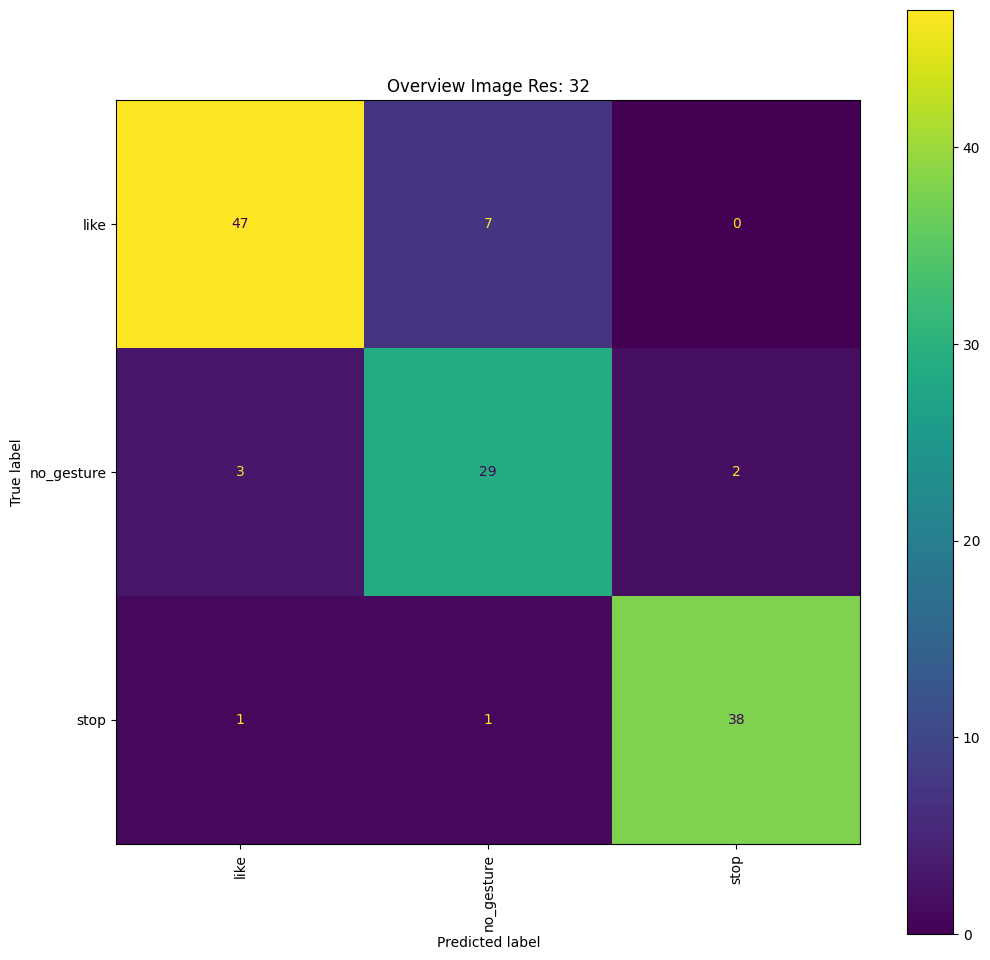

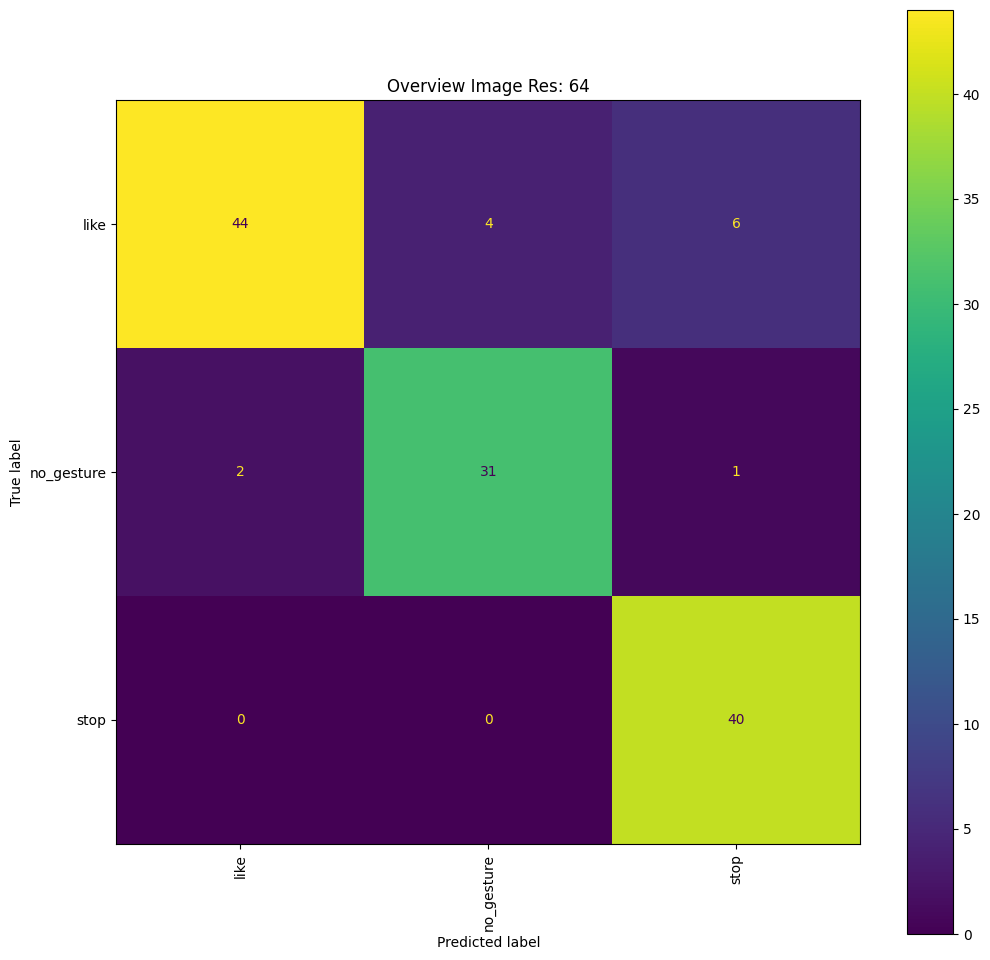

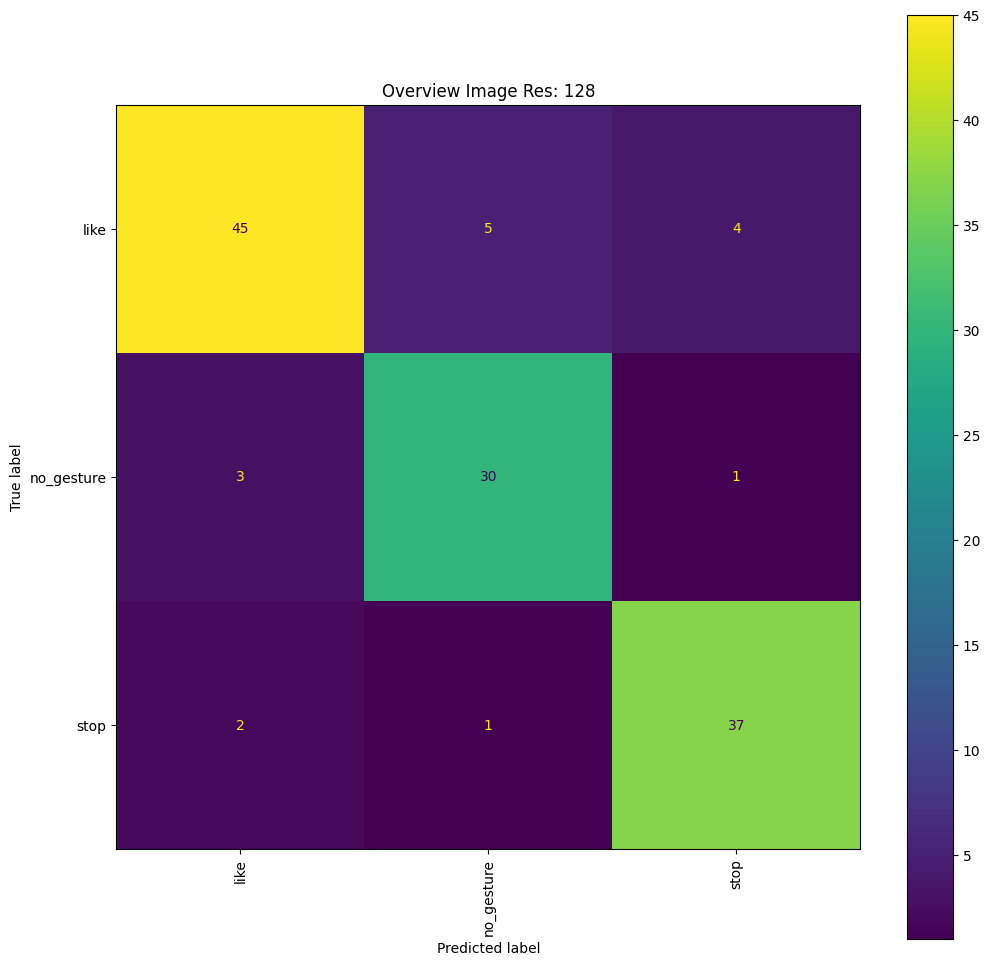

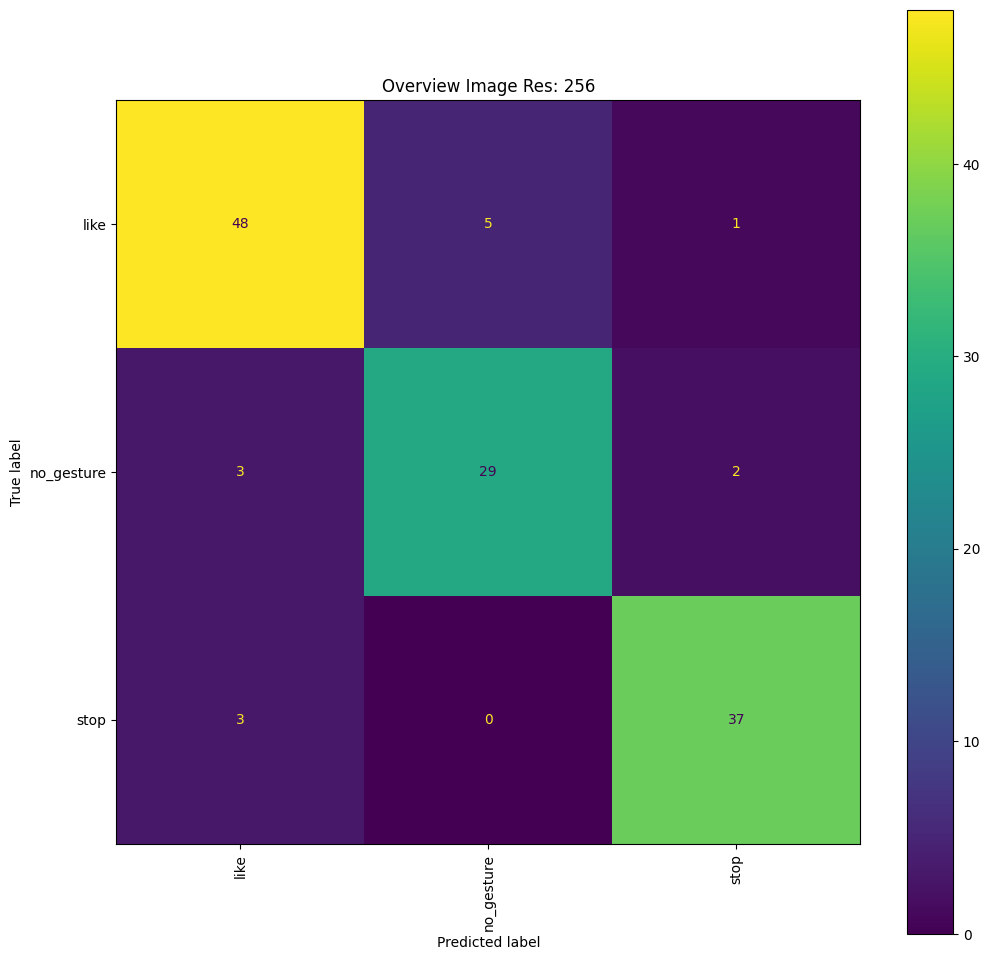

In [92]:
for index, confusion in enumerate(confusions):
    martrix = confusion[0]
    labels = confusion[1]

    fig = plt.figure(figsize=(12, 12))
    ConfusionMatrixDisplay(martrix, display_labels=labels).plot(ax=plt.gca())
    plt.xticks(rotation=90, ha='center')
    
    plt.title(f'Overview Image Res: {IMG_SIZES[index]}')
    
    plt.show()

# Example image of different resolutions

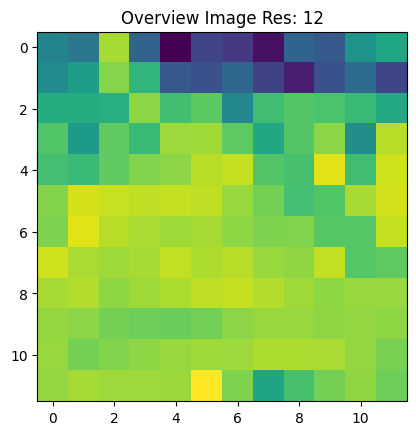

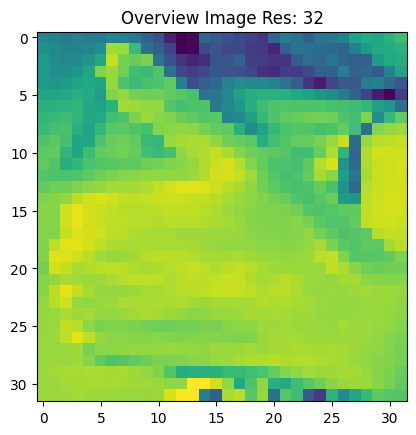

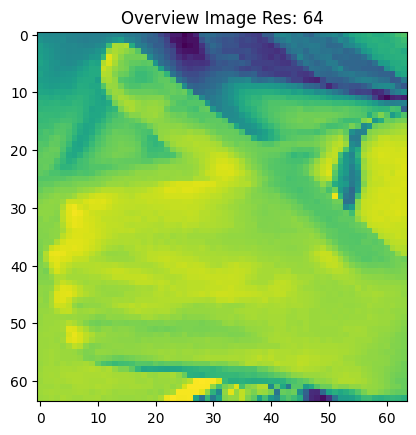

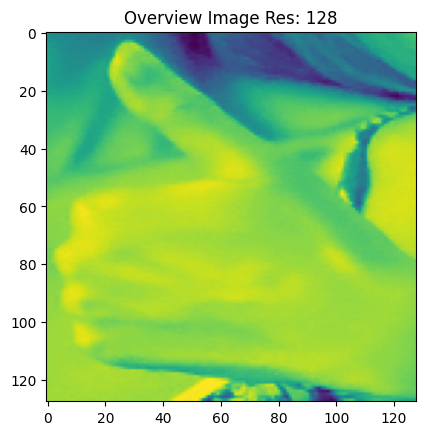

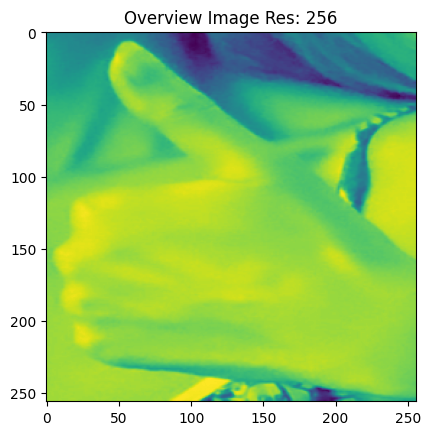

In [93]:
for index, ex_img in enumerate(example_images):
    plt.imshow(ex_img)
    plt.title(f'Overview Image Res: {IMG_SIZES[index]}')
    plt.show()


# Final Results

## Findings

### 12x12
- performance increase is slow
- validation accuracy is ok (ca. 0.78)
- loss value is high witch ca. 0.6
- fastes trianing time and predition time
- many wrong predictions

### 32x32
- Way better result than 12x12 > fewer wrong predictions
- almost as fast in train and prediction as 12x12 (difference is not really there)
- loss is way lower > it is ok > could still be better 
- accuracy is way better, also is getting better with less epochs (way faster) and loss value is getting faster low than it was with 12x12

### 64x64
- still fast training time (is good with ca. 21 seconds)
- prediction time is still very good
- better results than 32x32 > better accuracy and validation values
- loss is only a tiny bit better

### 128x128
- accuracy is same as 64x64
- train time is way longer (ca 2 times the lenght of 64x64)
- predicition time is way longer > more latency > but still very acceptable
- more wrong predictions than 64x64 (only 3 predictions more but still)
- best result for loss

### 256x256
- very long train time in comparison (5 times to 128)
- almost a second more prediction time 
- accuracy is worse than 128 and 64 (ca. 0.02 worse) ca same accuracy as 32 but more loss
- loss is getting higher again

# Summary

All in all it seems like 64x64 is the best resolution to train with and therefore would be my recommondation.
- accuracy is as high as 128 and higher than 256
- train and prediction time is still very fast
- performance in prediciton is way better than 12x12 
- performance is a little bit better than 32x32 128x128 and 256x256
	
The biggest and most noticable step was from 12x12 to 32x32 with way better values for accuracy and loss in 32x32. With higher resolutions like 128x128 and 256x256 the loss and the accuracy on the validation dataset is getting worse again. This seems weird at first glance but could be a sign of overfitting.

